In [ ]:
import json
import sys
from collections import Counter
from dataclasses import dataclass
from typing import List, Tuple

import cv2
import networkx as nx
import numpy as np
import scipy.ndimage.measurements
import shapely.geometry
from PIL import Image
from skimage import morphology, segmentation
import matplotlib.pyplot as plt

In [3]:
# code from https://github.com/danvk/extract-raster-network

def find_color(im: Image, rgb: Tuple[int]) -> np.ndarray:
    """Given an RGB image, return an ndarray with 1s where the pixel is the given color."""
    px = np.asarray(im)
    out = np.zeros(im.size, dtype=np.uint8)
    r, g, b = rgb
    out[(px[:, :, 0] == r) & (px[:, :, 1] == g) & (px[:, :, 2] == b)] = 1
    return out


def zhang_suen_node_detection(skel: np.ndarray) -> List[Tuple[int]]:
    """Find nodes based on a skeletonized bitmap.

    (From nefi) Node detection based on criteria put forward in "A fast parallel algorithm
    for thinning digital patterns" by T. Y. Zhang and C. Y. Suen. Pixels p of the skeleton
    are categorized as nodes/non-nodes based on the value of a function A(p) depending on
    the pixel neighborhood of p. Please check the above paper for details.

    A(p1) == 1: The pixel p1 sits at the end of a skeleton line, thus a node
    of degree 1 has been found.
    A(p1) == 2: The pixel p1 sits in the middle of a skeleton line but not at
    a branching point, thus a node of degree 2 has been found. Such nodes are
    ignored and not introduced to the graph.
    A(p1) >= 3: The pixel p1 belongs to a branching point of a skeleton line,
    thus a node of degree >=3 has been found.

    Args:
        *skel* : Skeletonised source image. The skeleton must be exactly 1 pixel wide.

    Returns:
        *nodes* : List of (x, y) coordinates of nodes
    """
    skel = np.pad(skel, 1)
    item = skel.item

    def check_pixel_neighborhood(x, y, skel):
        """
        Check the number of components around a pixel.
        If it is either 1 or more than 3, it is a node.
        """
        p2 = item(x - 1, y)
        p3 = item(x - 1, y + 1)
        p4 = item(x, y + 1)
        p5 = item(x + 1, y + 1)
        p6 = item(x + 1, y)
        p7 = item(x + 1, y - 1)
        p8 = item(x, y - 1)
        p9 = item(x - 1, y - 1)

        # The function A(p1),
        # where p1 is the pixel whose neighborhood is beeing checked
        components = (
            (p2 == 0 and p3 == 1)
            + (p3 == 0 and p4 == 1)
            + (p4 == 0 and p5 == 1)
            + (p5 == 0 and p6 == 1)
            + (p6 == 0 and p7 == 1)
            + (p7 == 0 and p8 == 1)
            + (p8 == 0 and p9 == 1)
            + (p9 == 0 and p2 == 1)
        )
        return (components >= 3) or (components == 1)

    nodes = []
    w, h = skel.shape
    for x in range(1, w - 1):
        for y in range(1, h - 1):
            if item(x, y) != 0 and check_pixel_neighborhood(x, y, skel):
                nodes.append((x - 1, y - 1))
    return nodes


def find_dense_skeleton_nodes(skel: np.ndarray) -> List[Tuple[int, int]]:
    """Find "dense" (2x2 or larger) regions in the skeleton."""
    eroded = morphology.binary_erosion(np.pad(skel, 1), np.ones((2, 2)))[1:-1, 1:-1]

    # Find the centers of mass of connected components
    labeled_array, num_features = scipy.ndimage.measurements.label(eroded)
    centers = scipy.ndimage.measurements.center_of_mass(eroded, labeled_array, [*range(1, num_features+1)])
    return [(int(x), int(y)) for (x, y) in centers]


def add_dense_nodes(nodes: List[Tuple[int, int]], dense_nodes: List[Tuple[int, int]], min_distance = 5) -> List[Tuple[int, int]]:
    """Add in new nodes which are distinct from the old ones."""
    keep = []
    min_d2 = min_distance ** 2
    for node in dense_nodes:
        x, y = node
        is_ok = True
        for nx, ny in nodes:
            d2 = (x - nx) **2 + (y - ny) ** 2
            if d2 < min_d2:
                is_ok = False
                break
        if is_ok:
            keep.append(node)

    print(f'Adding {len(keep)}/{len(dense_nodes)} dense nodes to existing {len(nodes)} nodes.')
    return [*nodes, *keep]


@dataclass
class Path:
    start: Tuple[int, int]
    stop: Tuple[int, int]
    path: List[Tuple[int, int]]


def is_new_path(paths: List[Path], path: Path) -> bool:
    """Is this a new path, or does it overlap signficantly with existing paths?"""
    candidates = [p for p in paths if p.start == path.start and p.stop == path.stop]
    other_points = {coord for p in candidates for coord in p.path[1:-1]}
    interior = set(path.path[1:-1])
    if other_points & interior:
        return False
    return True


def is_valid_self_loop(path: List[Tuple[int, int]], min_self_loop_distance: int) -> bool:
    if len(path) < min_self_loop_distance:
        return False
    # Only the end node can appear twice in a self-loop
    return len([c for c, n in Counter(path).items() if n >= 2]) == 1


def find_paths(skel: np.ndarray, nodes: List[Tuple[int]], min_distance=5) -> List[Path]:
    """Find paths between nodes in the graph using the connectivity in the skeleton.

    This returns a list of edges (pairs of nodes) with the following properties.
        - path: list of coordinates connecting the nodes (including the nodes)
        - d: length of the path

    This will early-out if a path shorter than min_distance is found.

    There may be multiple distinct paths between the same nodes, or a path between a node and itself.
    """
    width, height = skel.shape

    def neighbors(x, y):
        for dy in (-1, 0, 1):
            cy = y + dy
            if cy < 0 or cy >= height:
                continue
            for dx in (-1, 0, 1):
                cx = x + dx
                if (dx != 0 or dy != 0) and 0 <= cx < width and skel[cx, cy]:
                    yield cx, cy

    # each cell points back to its parent
    parents = {n: None for n in nodes}

    def trace_back(node):
        trace = []
        while node:
            trace.append(node)
            node = parents.get(node)
        return trace

    d = {n: 0 for n in nodes}  # used to avoid backtracking

    edges = []
    frontier = [*nodes]
    while frontier:
        next_frontier = []
        for n in frontier:
            x, y = n
            for c in neighbors(x, y):
                if c not in parents:
                    parents[c] = n
                    next_frontier.append(c)
                    d[c] = 1 + d[n]
                else:
                    if d[c] >= d[n]:
                        # we've got a connection! Follow both cells back to trace it out
                        tn = trace_back(n)
                        tc = trace_back(c)
                        tc.reverse()
                        path = [*tc, *tn]
                        endpoints = (path[0], path[-1])
                        start, stop = min(endpoints), max(endpoints)
                        new_path = Path(start, stop, path)
                        # Ignore redundant paths and short self-loops
                        if is_new_path(edges, new_path) and (
                            start != stop or is_valid_self_loop(path, min_distance)
                        ):
                            edges.append(new_path)
                            if len(path) - 1 < min_distance:
                                # This edge will get pruned out anyway, so no need to keep looking.
                                return edges

        frontier = next_frontier

    return edges


def merge_nodes(
    nodes: List[Tuple[int, int]], edges: List[Path], n1: Tuple[int, int], n2: Tuple[int, int]
) -> List[Tuple[int, int]]:
    ends = {n1, n2}
    paths = [e.path for e in edges if {e.start, e.stop} == ends]
    assert paths
    path = min(paths, key=lambda p: len(p))
    idx = len(path) // 2
    new_node = path[idx]
    return [new_node] + [n for n in nodes if n != n1 and n != n2]


def make_graph(nodes: List[Tuple[int, int]], edges: List[Path]) -> nx.MultiGraph:
    g = nx.MultiGraph()
    g.add_nodes_from(nodes)
    for edge in edges:
        g.add_edge(edge.start, edge.stop, path=edge.path, d=len(edge.path) - 1)
    return g


def connect_graph(skel: np.ndarray, min_distance: int) -> nx.MultiGraph:
    """Iteratively produce a graph, merging nodes until none are < min_distance apart."""
    nodes = zhang_suen_node_detection(skel)
    dense_nodes = find_dense_skeleton_nodes(skel)
    nodes = add_dense_nodes(nodes, dense_nodes)
    edges = find_paths(skel, nodes, min_distance)

    any_changed = True
    while any_changed:
        any_changed = False
        for edge in edges:
            d = len(edge.path) - 1
            if d < min_distance:
                n1 = edge.start
                n2 = edge.stop
                nodes = merge_nodes(nodes, edges, n1, n2)
                edges = find_paths(skel, nodes, min_distance)
                #print(f'Merged {n1} and {n2}, d={d}')
                any_changed = True
                if n1 == n2:
                    any_changed = False
                break

    # All good!
    return make_graph(nodes, edges)


def simplify_paths(g: nx.Graph, tolerance=1) -> nx.Graph:
    for n1, n2, k in g.edges(keys=True):
        g[n1][n2][k]['path'] = shapely.geometry.LineString(g[n1][n2][k]['path']).simplify(tolerance)
    return g


def extract_network(px: np.ndarray, min_distance=30) -> nx.Graph:
    skel = morphology.skeletonize(px)
    print(f'Skeleton px={skel.sum()}')
    g = connect_graph(skel, min_distance)
    g = simplify_paths(g)
    return g


def create_circular_mask(shape, center, radius):
    w, h = shape
    cx, cy = center
    X, Y = np.ogrid[:w, :h]
    dist_from_center = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)
    mask = dist_from_center <= radius
    return mask


def render_network(im: Image, graph: nx.Graph, rgb: Tuple[int]) -> Image:
    """Produce a rendering of the extracted street network on top of the image.

    Streets (nodes and edges) are colored rgb.
    """
    r, g, b = rgb
    px = np.asarray(im).copy()

    for x, y in graph.nodes():
        circle = create_circular_mask(px.shape[0:2], (y, x), 4).astype(np.uint8)
        # clean this up
        px[:, :, 0] += r * circle
        px[:, :, 1] += g * circle
        px[:, :, 2] += b * circle

    for (n1, n2, k) in graph.edges(keys=True):
        path = graph[n1][n2][k]['path']
        for pt1, pt2 in zip([*path.coords][:-1], [*path.coords][1:]):
            y1, x1 = pt1
            y2, x2 = pt2
            cv2.line(px, (int(y1), int(x1)), (int(y2), int(x2)), color=rgb, thickness=1)
        for (x, y) in path.coords:
            circle = create_circular_mask(px.shape[0:2], (y, x), 2).astype(np.uint8)
            px[:, :, 0] += r * circle
            px[:, :, 1] += g * circle
            px[:, :, 2] += b * circle
    return Image.fromarray(px)


def render_skeleton(im: Image, skel: np.ndarray, rgb: Tuple[int]) -> Image:
    r, g, b = rgb
    px = np.asarray(im).copy()
    skel = skel.T
    px[skel > 0, 0] = r
    px[skel > 0, 1] = g
    px[skel > 0, 2] = b
    return Image.fromarray(px)


# Sum of the min & max of (a, b, c)
def hilo(a, b, c):
    if c < b:
        b, c = c, b
    if b < a:
        a, b = b, a
    if c < b:
        b, c = c, b
    return a + c


def complement(rgb):
    """Return a complementary color; see https://stackoverflow.com/a/40234924/388951"""
    k = hilo(*rgb)
    return tuple(k - u for u in rgb)


def network_to_geojson(g: nx.Graph):
    return {
        'type': 'FeatureCollection',
        'features': [
            {
                'type': 'Feature',
                'id': f'street-{i}',
                'properties': {
                    'street': i,
                    'len': (e := g[n1][n2][k])['d'],
                    'start': (coords := e['path'].coords)[0],
                    'stop': coords[-1],
                },
                'geometry': [*coords],
            }
            for i, (n1, n2, k) in enumerate(g.edges(keys=True))
        ],
    }


In [23]:
png_files = ["model_rendered.png"]
rgb = (0,0,255)

degree_sequences = []

for file in png_files:
    im = Image.open(file)
    px = find_color(im, rgb).T
    g = extract_network(px)

    # clean up the graph
    G = nx.Graph(g)
    G.remove_edges_from(nx.selfloop_edges(G))
    remove = [node for node, degree in G.degree() if degree < 1]
    G.remove_nodes_from(remove)

    # get degree distributions
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    degree_sequences.append(degree_sequence)

Skeleton px=6881
Adding 2/54 dense nodes to existing 1204 nodes.


/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_47320/4245138443.py:93: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  labeled_array, num_features = scipy.ndimage.measurements.label(eroded)
/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_47320/4245138443.py:94: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  centers = scipy.ndimage.measurements.center_of_mass(eroded, labeled_array, [*range(1, num_features+1)])


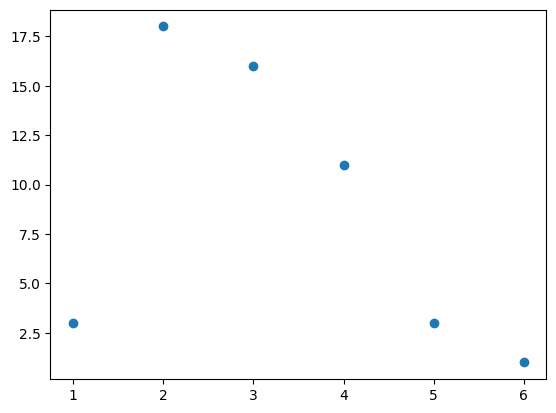

In [27]:
plt.scatter(*np.unique(degree_sequences[0], return_counts=True))